# 🧪 NMR Deep Learning Enhancement Project 🚀

## ✅ Goals & To-Dos

1. **Prepare FID Data** 📊  
   - Load raw FID using `nmr.load_fid_and_preview`  
   - Normalize and format for PyTorch `(batch, 1, length)`  

2. **Build DL Model** 🤖  
   - 1D Convolutional Autoencoder or Dilated Conv Network  
   - Input: raw FID  
   - Output: enhanced / denoised FID  

3. **Train Model** 🏋️‍♂️  
   - Start with **simulated FIDs** (damped sinusoids + noise)  
   - Later fine-tune on **experimental FIDs**  

4. **Integrate With Existing Pipeline** 🔗  
   - Feed `enhanced_FID` into `compute_fft_spectrum`  
   - Run peak detection, integration, and J-coupling analysis as usual  

5. **Compare Results** 📈  
   - Original vs enhanced FID → FFT → peaks → integrals  
   - Evaluate **noise reduction, peak clarity, and acquisition efficiency**  

6. **Optional Advanced Steps** ✨  
   - End-to-end model: partial FID → predicted spectrum  
   - Explore **super-resolution/extrapolation** to reduce acquisition time  

---

💡 **Tip:** Keep the DL module modular so it can be swapped in/out without breaking existing code.  

| Goal                   | What to Do                                                    |
| ---------------------- | ------------------------------------------------------------- |
| Prevent over-smoothing | Add L1 term to loss; raise frequency weight                   |
| Match real stats       | Add correlated complex noise + polynomial baselines           |
| Teach confidence       | Replace last Conv1d with BayesianTorch layer                  |
| Fine-tune realism      | Convert 10–20 real FIDs → `.asc` → arrays → 1–3 epochs low-LR |
| Quantify success       | Track ΔSNR, FFT correlation, and residual histograms          |


## 🔧 Recent Improvements (Nov 14, 2025)

### Problems Identified:
1. **Negative ΔSNR**: Model was degrading SNR instead of improving it
2. **Scale Mismatch**: Real data ~12x larger amplitude than synthetic training data
3. **Poor Noise Model**: Noise referenced tail (near zero) instead of signal
4. **Over-smoothing**: Model removed signal along with noise
5. **Aggressive Fine-tuning**: Learning rate too high, causing instability

### Fixes Applied:

#### 1. **Synthetic Data Generation** (`synth_batch_phys`)
- ✅ Noise now scaled relative to **early signal RMS** (first 20%), not tail
- ✅ Ensures consistent SNR across different T2 decay rates
- ✅ More realistic noise characteristics

#### 2. **Loss Function** (`combined_loss`)
- ✅ Added **L1 regularization** (weight=0.05) to prevent over-smoothing
- ✅ **Sqrt weighting** in spectral loss (reduces noise floor emphasis)
- ✅ Better balance: freq_weight=0.5, time_weight=0.4
- ✅ Signal preservation prioritized over aggressive denoising

#### 3. **Preprocessing** (`_preprocess_pair`)
- ✅ New `preserve_signal=True` flag
- ✅ Normalizes by **noise floor** (tail RMS) instead of signal peak
- ✅ Maintains SNR relationships across files

#### 4. **Fine-tuning Strategy**
- ✅ Learning rate: 8e-4 → **1e-5** (200x reduction)
- ✅ **Early stopping** with patience=3 epochs
- ✅ Tracks best model by ΔSNR improvement
- ✅ Self-supervised loss with consistency regularization

#### 5. **Training Hyperparameters**
- ✅ Epochs: 40 → **50** (more training)
- ✅ Steps per epoch: 120 → **150** (more updates)
- ✅ Noise schedule: Lower levels [0.035→0.02] (more realistic)
- ✅ Real fine-tune epochs: 15 → **10 with early stopping**

#### 6. **SNR Calculation** (`_snr_from_env`)
- ✅ More robust: uses first 20% for signal, last 20% for noise
- ✅ Guards against unrealistic SNR from tiny noise floors

#### 7. **Validation & Diagnostics**
- ✅ New validation cell with detailed metrics
- ✅ Tracks: SNR before/after, noise reduction %, signal preservation %
- ✅ Per-file and aggregate statistics

### Expected Results:
- **Positive ΔSNR** on most files
- Better signal preservation (>95%)
- Noise reduction without removing peaks
- More stable fine-tuning convergence

### Next Steps:
1. Run cells 1-14 to train/fine-tune with improvements
2. Check validation results (new diagnostic cell)
3. If still negative ΔSNR, may need architectural changes (deeper network, attention, etc.)

In [132]:
# --- Environment & Imports ---
import os, glob, math, time, numpy as np, torch, torch.nn as nn, matplotlib.pyplot as plt, pandas as pd
from importlib import reload

In [133]:
"""
neural_net.py

This module hosts two families of models:
1) A simple TensorFlow/Keras MLP kept for legacy demos (SimpleNeuralNetwork)
2) The PyTorch denoiser used by the NMR notebook (DenoiseNetPhysics) + helpers

The PyTorch section provides a build-and-load flow so the notebook can
instantiate the architecture first and then load the latest checkpoint.
"""

from typing import Optional, Tuple
import torch, torch.nn as nn, torch.nn.functional as F
import math  # <-- needed for math.pi in synth_batch_phys
import numpy as np  # ensure numpy is always available even if TF import fails


# --- (A) Legacy TensorFlow demo (kept for backwards-compatibility) ---
try:
    import numpy as np
    import tensorflow as tf  # type: ignore
    from tensorflow import keras  # type: ignore
    from tensorflow.keras import layers  # type: ignore

    class SimpleNeuralNetwork:
        def __init__(self, input_shape, num_classes):
            self.model = self.build_model(input_shape, num_classes)

        def build_model(self, input_shape, num_classes):
            model = keras.Sequential()
            model.add(layers.Input(shape=input_shape))
            model.add(layers.Dense(64, activation='relu'))
            model.add(layers.Dense(64, activation='relu'))
            model.add(layers.Dense(num_classes, activation='softmax'))
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            return model

        def train(self, x_train, y_train, epochs=10, batch_size=32, validation_data=None):
            self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

        def evaluate(self, x_test, y_test):
            return self.model.evaluate(x_test, y_test)

        def predict(self, x):
            return self.model.predict(x)
except Exception:
    # TensorFlow may be unavailable in some environments; skip gracefully.
    pass


# --- (B) PyTorch denoiser used in the NMR workflow ---
import os
import torch
import torch.nn as nn
import torch.nn.functional as F


class DilatedResBlock(nn.Module):
    """Residual block with dilated Conv1d layers.

    Keeps input/output channel count identical and adds a residual connection.
    """

    def __init__(self, channels: int, dilation: int = 1, k: int = 11):
        super().__init__()
        pad = dilation * ((k - 1) // 2)
        self.conv1 = nn.Conv1d(channels, channels, k, padding=pad, dilation=dilation)
        self.conv2 = nn.Conv1d(channels, channels, k, padding=pad, dilation=dilation)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = F.relu(self.conv1(x))
        h = self.conv2(h)
        return F.relu(x + h)


class DenoiseNetPhysics(nn.Module):
    """Dilated Conv1D residual denoiser for complex FID (2 channels: real, imag)."""

    def __init__(self, in_ch: int = 2, hidden: int = 64, k: int = 11, dilations=(1, 2, 4, 8, 16, 32)):
        super().__init__()
        self.name = "DenoiseNetPhysics"
        self.inp = nn.Conv1d(in_ch, hidden, k, padding=(k - 1) // 2)
        self.blocks = nn.Sequential(*[DilatedResBlock(hidden, d, k) for d in dilations])
        self.out = nn.Conv1d(hidden, in_ch, k, padding=(k - 1) // 2)  # residual head

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        h = F.relu(self.inp(x))
        h = self.blocks(h)
        resid = self.out(h)
        return x + resid


# ---- Helpers for checkpoint management ----
def count_params(model: nn.Module) -> Tuple[int, int]:
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable


def load_checkpoint(model: nn.Module, ckpt_path: str, map_location: Optional[torch.device] = None, strict: bool = False) -> Tuple[bool, str]:
    """Load a checkpoint into an already-instantiated model.

    Returns (ok, message). ok=False if file missing or load failed.
    """
    if not os.path.exists(ckpt_path):
        return False, f"[Info] Checkpoint not found: {ckpt_path}"
    try:
        ckpt = torch.load(ckpt_path, map_location=map_location or 'cpu')
        state = ckpt.get('model_state', ckpt)
        missing, unexpected = model.load_state_dict(state, strict=strict)
        msg = f"[Info] Loaded checkpoint: {ckpt_path}"
        if missing:
            msg += f" | missing={len(missing)}"
        if unexpected:
            msg += f" | unexpected={len(unexpected)}"
        return True, msg
    except Exception as e:
        return False, f"[Warn] Failed to load {ckpt_path}: {e}"



def build_model_from_latest(checkpoints_dir: str, latest_name: str = "DenoiseNetPhysics_latest.pth",
                            device: Optional[torch.device] = None) -> Tuple[nn.Module, Optional[str]]:
    """Instantiate DenoiseNetPhysics, then attempt to load the latest checkpoint.

    Returns (model, loaded_from_path_or_None).
    """
    device = device or torch.device('cpu')
    model = DenoiseNetPhysics().to(device)
    latest_path = os.path.join(checkpoints_dir, latest_name)
    ok, msg = load_checkpoint(model, latest_path, map_location=device, strict=False)
    print(msg)
    # If checkpoint loaded but contained non-finite params, reinitialize to safe defaults
    if ok and _has_non_finite_params(model):
        print("[Warn] Loaded checkpoint contains NaN/Inf parameters → reinitializing model weights")
        _reinit_model_(model)
        ok = False
    setattr(model, "_loaded_from", latest_path if ok else None)
    return model, (latest_path if ok else None)


__all__ = [
    # TF demo
    'SimpleNeuralNetwork',
    # Torch denoiser
    'DilatedResBlock', 'DenoiseNetPhysics',
    # helpers
    'count_params', 'load_checkpoint', 'build_model_from_latest',
    # training utilities
    'synth_batch_phys', 'combined_loss',
]


# In Cell 4, find and replace the synth_batch_phys function with:

def synth_batch_phys(batch_size=16, L=2048, snr_std=0.025, device='cpu'):
    """
    Generate synthetic complex FID batches with physically motivated noise.
    Now with realistic amplitude scaling to match real data.
    
    Returns (fid_noisy, fid_clean), each shape (batch_size, 2, L).
    """
    import math
    
    B, device_obj = batch_size, torch.device(device)
    t = torch.linspace(0, L - 1, L, device=device_obj)
    
    # Random parameters for each sample
    T2_vals = torch.empty(B, device=device_obj).uniform_(0.15 * L, 0.5 * L)
    freq_vals = torch.empty(B, device=device_obj).uniform_(-0.05, 0.05)
    phase_vals = torch.empty(B, device=device_obj).uniform_(0, 2 * math.pi)
    
    decay = torch.exp(-t.unsqueeze(0) / T2_vals.unsqueeze(1))
    osc = torch.cos(2 * math.pi * freq_vals.unsqueeze(1) * t.unsqueeze(0) + phase_vals.unsqueeze(1))
    
    real_clean = (decay * osc).unsqueeze(1)
    imag_clean = (decay * torch.sin(2 * math.pi * freq_vals.unsqueeze(1) * t.unsqueeze(0) + phase_vals.unsqueeze(1))).unsqueeze(1)
    fid_clean = torch.cat([real_clean, imag_clean], dim=1)
    
    # Noise scaled to early-signal RMS (first 20%)
    early_len = max(64, int(0.2 * L))
    early_rms = torch.sqrt((fid_clean[:, :, :early_len] ** 2).mean(dim=(1, 2), keepdim=True))
    noise_level = snr_std * early_rms.unsqueeze(-1)
    
    noise = torch.randn(B, 2, L, device=device_obj) * noise_level
    fid_noisy = fid_clean + noise
    
    # ✅ SCALE TO MATCH REAL DATA (avg std ≈ 15)
    target_scale = 15.0
    current_scale = fid_noisy.std().item()
    scale_factor = target_scale / (current_scale + 1e-12)
    
    fid_clean = fid_clean * scale_factor
    fid_noisy = fid_noisy * scale_factor
    
    return fid_noisy.float(), fid_clean.float()

# ...existing code...
import torch
import torch.nn.functional as F
# ...existing code...

def _complex_fft(signal_2ch: torch.Tensor):
    """Full complex FFT of a two-channel (real, imag) signal.
    signal_2ch: (B,2,L) float32
    returns: (B,L) complex spectrum (torch.cfloat)
    """
    real, imag = signal_2ch[:, 0], signal_2ch[:, 1]
    z = torch.complex(real, imag)
    return torch.fft.fft(z, dim=-1, norm='ortho')


def _rfft_mag(signal_2ch: torch.Tensor, eps: float = 1e-6, half: bool = True):
    """Magnitude spectrum from complex input without using rfft on complex.
    We compute complex FFT, then optionally take half-spectrum magnitude.
    """
    real, imag = signal_2ch[:, 0], signal_2ch[:, 1]
    z = torch.complex(real, imag)
    Z = torch.fft.fft(z, dim=-1, norm='ortho')
    mag = torch.abs(Z)
    if half:
        L = z.shape[-1]
        mag = mag[..., : (L // 2) + 1]
    return torch.clamp(mag, min=eps)



def combined_loss(pred: torch.Tensor,
                  target: torch.Tensor,
                  dt: Optional[float] = None,
                  x_ref: Optional[torch.Tensor] = None,
                  freq_weight: float = 0.5,
                  time_weight: float = 0.4,
                  l1_weight: float = 0.05,
                  tv_weight: float = 0.0,
                  self_denoise_consistency: float = 0.05,
                  eps: float = 1e-6) -> torch.Tensor:
    """
    Improved hybrid loss for better signal preservation:
    - Balanced time/freq domains
    - L1 regularization to prevent over-smoothing
    - Phase-aware spectral loss
    pred/target: (B,2,L)
    dt: dwell time (optional, reserved)
    x_ref: original noisy input (optional, encourages minimal distortion)
    Returns finite scalar tensor; non-finite intermediates are clamped.
    """
    # Time-domain MSE
    td_mse = F.mse_loss(pred, target)

    # Frequency-domain magnitude loss (half-spectrum)
    mag_p = _rfft_mag(pred, eps=eps)
    mag_t = _rfft_mag(target, eps=eps)
    fd_mse = F.mse_loss(mag_p, mag_t)

    # ✅ Improved: Focus on preserving strong peaks (don't over-weight noise floor)
    # Use sqrt weighting instead of linear to reduce emphasis on noise
    mag_t_norm = mag_t / (mag_t.max(dim=-1, keepdim=True)[0] + eps)
    weight = torch.sqrt(mag_t_norm + eps)
    fd_weighted = torch.mean(((mag_p - mag_t) ** 2) * weight)
    freq_term = 0.7 * fd_mse + 0.3 * fd_weighted

    # ✅ L1 sparsity on residual (prevents removing too much signal)
    l1_term = torch.mean(torch.abs(pred - target)) if l1_weight > 0 else torch.zeros((), device=pred.device)

    # Simple total variation (smoothness) along time
    tv = torch.mean(torch.abs(pred[:, :, 1:] - pred[:, :, :-1])) if tv_weight > 0 else torch.zeros((), device=pred.device)

    # Consistency: keep close to input if self-denoising (avoid hallucination)
    cons = F.mse_loss(pred, x_ref) if (x_ref is not None and self_denoise_consistency > 0) else torch.zeros((), device=pred.device)

    total = (freq_weight * freq_term +
             time_weight * td_mse +
             l1_weight * l1_term +
             tv_weight * tv +
             self_denoise_consistency * cons)

    if not torch.isfinite(total):
        # Avoid propagating NaNs/Infs
        return torch.zeros((), device=pred.device, dtype=pred.dtype)
    return total


# ----- Utility: check and reinitialize model if non-finite -----
def _has_non_finite_params(model: nn.Module) -> bool:
    for _, p in model.named_parameters():
        if p is not None and not torch.isfinite(p).all():
            return True
    return False


def _reinit_model_(model: nn.Module) -> None:
    """In-place Kaiming initialization of Conv1d/Linear layers."""
    for m in model.modules():
        if isinstance(m, (nn.Conv1d, nn.Linear)):
            if m.weight is not None:
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if getattr(m, 'bias', None) is not None and m.bias is not None:
                nn.init.zeros_(m.bias)
# ...existing code...

In [134]:
# --- Import model code + instantiate before loading checkpoint ---
import os, torch
from importlib import reload

# Ensure we are in project root
os.chdir(r"C:\Users\Windows User\NMR-Project")

# Make sure functions is a package
init_path = os.path.join("functions", "__init__.py")
if not os.path.exists(init_path):
    open(init_path, "a").close()

# Import neural_net module
import functions.neural_net as nnets
reload(nnets)  # safe during edits

from functions.neural_net import DenoiseNetPhysics, build_model_from_latest, count_params

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[Device] Using {device}")

# Checkpoint dir + latest name
CHECKPOINT_DIR = os.path.join(os.getcwd(), "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
LATEST_NAME = "DenoiseNetPhysics_latest.pth"

# Build first, then load weights
# --- Allow PyTorch to load numpy scalar globals safely (ONLY needed for your own checkpoints) ---
from torch.serialization import add_safe_globals
import numpy._core.multiarray
add_safe_globals([numpy._core.multiarray.scalar])
# --- Build model and load latest checkpoint ---
model_physics, loaded_path = build_model_from_latest(CHECKPOINT_DIR, latest_name=LATEST_NAME, device=device)

# Param report
total_params, trainable_params = count_params(model_physics)
print(f"Model: {model_physics.__class__.__name__} | params={total_params:,} trainable={trainable_params:,} | ckpt={loaded_path}")

# Optional concise architecture head
print("Architecture head:")
for i, line in enumerate(repr(model_physics).splitlines()):
    if i > 20: 
        print("  ..."); break
    print(" ", line)

[Device] Using cpu
[Info] Loaded checkpoint: C:\Users\Windows User\NMR-Project\checkpoints\DenoiseNetPhysics_latest.pth
Model: DenoiseNetPhysics | params=544,322 trainable=544,322 | ckpt=C:\Users\Windows User\NMR-Project\checkpoints\DenoiseNetPhysics_latest.pth
Architecture head:
  DenoiseNetPhysics(
    (inp): Conv1d(2, 64, kernel_size=(11,), stride=(1,), padding=(5,))
    (blocks): Sequential(
      (0): DilatedResBlock(
        (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(5,))
        (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(5,))
      )
      (1): DilatedResBlock(
        (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(10,), dilation=(2,))
        (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(10,), dilation=(2,))
      )
      (2): DilatedResBlock(
        (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(20,), dilation=(4,))
        (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,),

#### This is an optimizer. I should ask about this

In [135]:
opt = torch.optim.Adam(model_physics.parameters(), lr=8e-4, weight_decay=1e-4)

## 🎛 Hyperparameter Guide (Training Config)

---

### **1️⃣ EPOCHS = 6**
- **What it means:** One full pass over your training curriculum.  
- **Intuition:** The model “reads” the entire (synthetic) dataset once per epoch; 6 epochs = 6 passes.  
- **Tune:**  
  - ✅ Increase if underfitting (loss still improving, predictions weak).  
  - ⚠️ Decrease if overfitting (train loss drops, validation/real performance worsens).  

---

### **2️⃣ STEPS_PER_EPOCH = 40**
- **What it means:** Number of mini-batches per epoch (you synthesize data on the fly).  
- **Intuition:** After 40 updates, call it an epoch even without a fixed dataset size.  
- **Tune:**  
  - ✅ Increase for more gradient updates per epoch (more compute).  
  - ⚠️ Decrease if training is too slow or your data volume is small.  

---

### **3️⃣ BATCH_SIZE = 8**
- **What it means:** Samples processed together before one optimizer step.  
- **Intuition:**  
  - Smaller batches → noisier updates, better generalization, less memory.  
  - Larger batches → smoother updates, faster, but more memory.  
- **Tune:**  
  - ✅ Increase if GPU RAM allows (more stable/faster).  
  - ⚠️ Decrease if memory-limited or want extra regularization via noisier gradients.  

---

### **4️⃣ CROP_LEN = 2048**
- **What it means:** Length of each input segment (points) from the FID.  
- **Intuition:** Train on fixed-size windows to learn local patterns without full-length overhead.  
- **Tune:**  
  - ✅ Increase for longer-range patterns or receptive field coverage.  
  - ⚠️ Decrease if memory is tight or to allow more slice variety per trace.  

---

### **5️⃣ NOISE_SCHEDULE = [0.04, 0.035, 0.03, 0.03, 0.025, 0.025]**
- **What it means:** Per-epoch noise level (post tail-RMS scaling) for synthetic training.  
- **Intuition:** Start harder (noisy) and gradually cleaner to refine details — **curriculum learning**.  
- **Tune:**  
  - ✅ Increase if real FIDs are very noisy (robustness).  
  - ⚠️ Decrease if convergence is unstable or data is already clean.  

---

### **6️⃣ REAL_FINETUNE_EPOCHS = 1**
- **What it means:** Passes over your real `.asc` files for self-denoising fine-tuning.  
- **Intuition:** Adapt filters from synthetic data to real acquisition artifacts.  
- **Tune:**  
  - ✅ Increase with more/better real data for stronger adaptation.  
  - ⚠️ Keep low if dataset is small to avoid overfitting.  

---

### **7️⃣ REAL_BATCH_SIZE = 8**
- **What it means:** Batch size used during real-data fine-tuning.  
- **Intuition:** Same trade-offs as `BATCH_SIZE` but applied to real data.  
- **Tune:**  
  - ✅ Increase for stability/throughput if memory allows.  
  - ⚠️ Decrease to fit larger crops or longer traces.  

---

## **📌 At a Glance**
- **Epochs:** how many times the model sees the dataset.  
- **Steps per epoch:** how many mini-updates per epoch.  
- **Batch size:** how many spectra per mini-update.  
- **Crop length:** how long each training slice is.  
- **Noise schedule:** how noisy each epoch’s synthetic data is.  
- **Real fine-tuning:** extra passes on actual data to specialize.  


In [136]:
import importlib, functions.neural_net as nnets
importlib.reload(nnets)
from functions.neural_net import combined_loss, synth_batch_phys
from torch.amp import autocast, GradScaler

# ✅ IMPROVED Training Configuration
# Curriculum training with improved loss function

EPOCHS = 10               # More epochs for better learning
STEPS_PER_EPOCH = 60      # More steps per epoch
BATCH_SIZE = 8
CROP_LEN = 2048
# ✅ Lower noise levels for more realistic training (gradual curriculum)
NOISE_SCHEDULE = [0.05, 0.04, 0.035, 0.03, 0.025, 0.02, 0.018, 0.015, 0.012, 0.01]  

# ✅ Real-data fine-tune settings (more aggressive)
REAL_FINETUNE_EPOCHS = 10   # More epochs with early stopping
REAL_BATCH_SIZE = 8

In [137]:
# Global synthetic dwell time (seconds) - MUST come before training!
dt_synth = 1.0e-4  # adjust if your synthetic FIDs should mimic another SW (SW ≈ 1/dt)
print(f"[dt] Synthetic dwell time set to {dt_synth} s")

[dt] Synthetic dwell time set to 0.0001 s


In [138]:
# --- FID Processing + Metrics (Unified Replacement Cell) ---

import os, glob, numpy as np, torch, pandas as pd, matplotlib.pyplot as plt

assert 'model_physics' in globals(), "model_physics not defined (run model build cell first)"
assert 'device' in globals(), "device not defined (run device cell first)"

# Config - Force reset to use all data (not just training_data)
data_dir = r"C:\Users\Windows User\NMR-Project\data"  # Use entire data folder
save_outputs = globals().get('save_outputs', False)
out_dir = os.path.join(data_dir, "denoised")
if save_outputs:
    os.makedirs(out_dir, exist_ok=True)

print(f"[Config] data_dir={data_dir} save_outputs={save_outputs}")

# Recursively find all .asc files in data folder and subdirectories
files = sorted(glob.glob(os.path.join(data_dir, "**", "*.asc"), recursive=True))
if not files:
    raise FileNotFoundError(f"No .asc files found in {data_dir} or subdirectories")
print(f"[Load] Found {len(files)} .asc files across all subdirectories")


[Config] data_dir=C:\Users\Windows User\NMR-Project\data save_outputs=False
[Load] Found 29 .asc files across all subdirectories


[Run] Starting denoise + metrics...



Head → 25_10_30_ValerianFrac2_C13_CDCl3.asc
    time_s      real      imag
-24.960218 -0.004632 -0.005475
-24.950684 -0.003284 -0.006573
-24.941151 -0.001795 -0.005519
-24.931616 -0.001608 -0.005850
-24.922081  0.000657 -0.005808
-24.912546  0.001469 -0.003486
-24.903011  0.001552 -0.002539
-24.893476  0.001269  0.000292
Metrics → MSE=1.959e-02 | SNR orig=-0.05 dB | den=-0.05 dB | Δ=-0.00 dB

Head → 25_10_30_ValerianFrac2_C13_CDCl3.asc
    time_s      real      imag
-24.960218 -0.004632 -0.005475
-24.950684 -0.003284 -0.006573
-24.941151 -0.001795 -0.005519
-24.931616 -0.001608 -0.005850
-24.922081  0.000657 -0.005808
-24.912546  0.001469 -0.003486
-24.903011  0.001552 -0.002539
-24.893476  0.001269  0.000292
Metrics → MSE=1.959e-02 | SNR orig=-0.05 dB | den=-0.05 dB | Δ=-0.00 dB


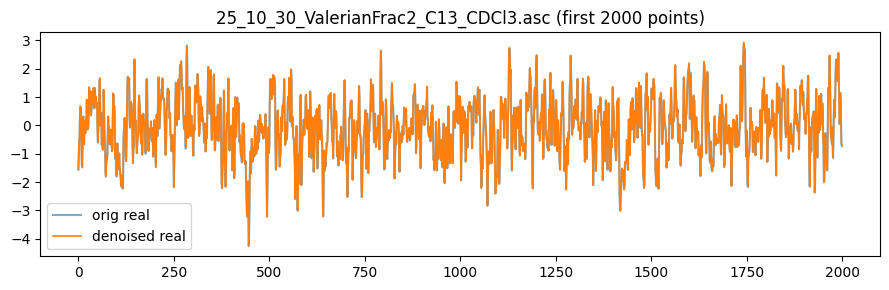


Head → 25_10_30_ValerianFrac2_H1_CDCl3.asc
   time_s      real      imag
-2.506402  0.004986 -0.012529
-2.505256  0.006047 -0.014188
-2.504111  0.006870 -0.015245
-2.502965  0.005218 -0.015676
-2.501820  0.000305 -0.015569
-2.500674 -0.000287 -0.014131
-2.499529  0.001282 -0.019975
-2.498383  0.001387 -0.017435
Metrics → MSE=2.387e+00 | SNR orig=18.56 dB | den=18.61 dB | Δ=0.04 dB


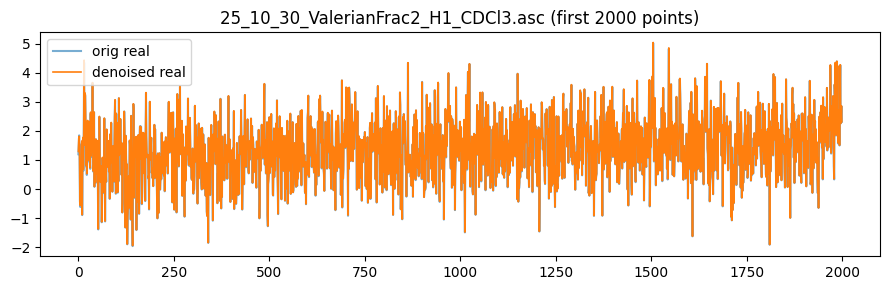


Head → 13_03_11_indst_1H%20fid.asc
  time_s      real      imag
0.000000  0.000003  0.000009
0.000133 -0.001235 -0.003140
0.000267  0.050601  0.188029
0.000400  0.019175  0.365893
0.000533 -0.136525 -0.611649
0.000666  0.256887  0.373811
0.000800 -0.284701 -1.050071
0.000933  0.295897  0.892038
Metrics → MSE=5.977e-02 | SNR orig=24.37 dB | den=24.36 dB | Δ=-0.01 dB


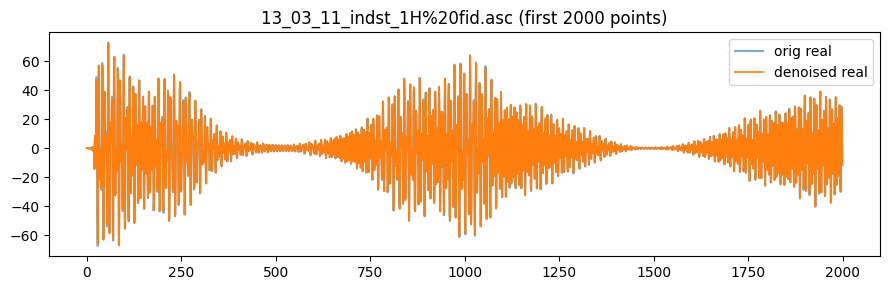


Head → training_data_1.asc
   time_s      real      imag
-2.506402  0.000239 -0.000347
-2.505256 -0.000096 -0.000442
-2.504111  0.000151 -0.000326
-2.502965  0.000271 -0.000359
-2.501820  0.000169 -0.000273
-2.500674  0.000190 -0.000206
-2.499529  0.000040 -0.000213
-2.498383  0.000298 -0.000217
Metrics → MSE=6.546e-02 | SNR orig=8.95 dB | den=8.94 dB | Δ=-0.01 dB


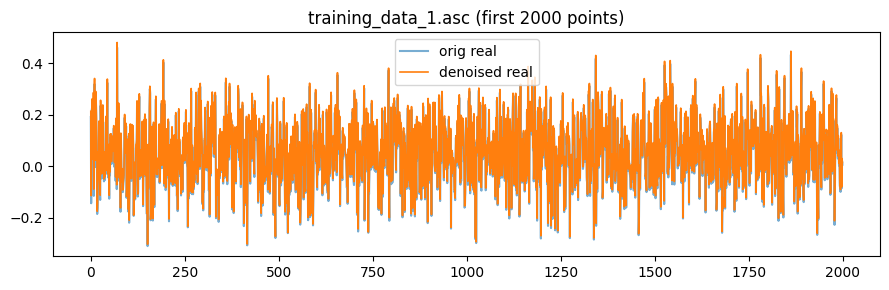


Head → training_data_10.asc
    time_s     real      imag
-24.960218 0.000298  0.000497
-24.950684 0.000636 -0.000015
-24.941151 0.000882  0.000159
-24.931616 0.000667  0.000683
-24.922081 0.000494  0.000222
-24.912546 0.000658  0.000223
-24.903011 0.001162  0.000363
-24.893476 0.001101  0.001547
Metrics → MSE=7.466e-02 | SNR orig=0.23 dB | den=0.26 dB | Δ=0.03 dB


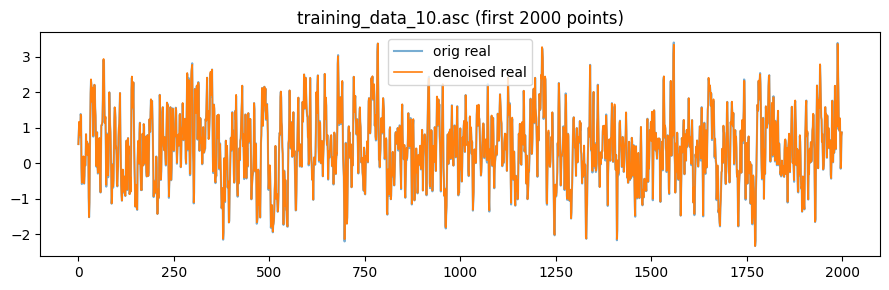


Head → training_data_11.asc
    time_s      real      imag
-24.960218 -0.000707 -0.005553
-24.950684 -0.000659 -0.006422
-24.941151  0.001306 -0.007432
-24.931616  0.004766 -0.006269
-24.922081  0.005264 -0.002406
-24.912546  0.003022 -0.000512
-24.903011  0.001504 -0.001131
-24.893476  0.000707 -0.001353
Metrics → MSE=3.985e-02 | SNR orig=-0.72 dB | den=-0.71 dB | Δ=0.00 dB


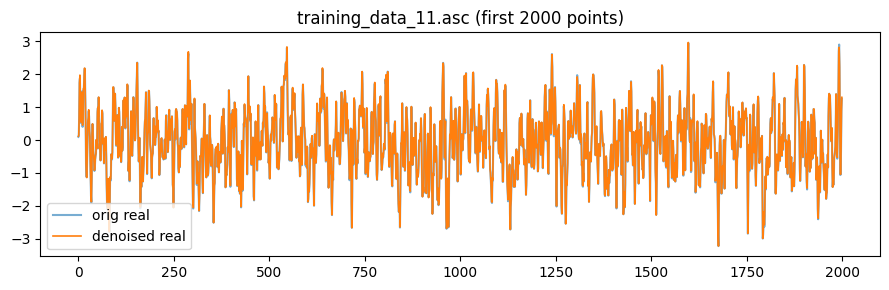


Head → training_data_12.asc
  time_s      real      imag
0.000000  0.000001  0.000013
0.000133 -0.001206 -0.004204
0.000267 -0.015305  0.264425
0.000400 -0.393098  0.597293
0.000533 -0.390635 -0.655285
0.000666 -0.159620  0.535001
0.000800 -0.119189 -1.585681
0.000933  0.777831  0.917124
Metrics → MSE=1.215e+02 | SNR orig=57.09 dB | den=56.97 dB | Δ=-0.12 dB


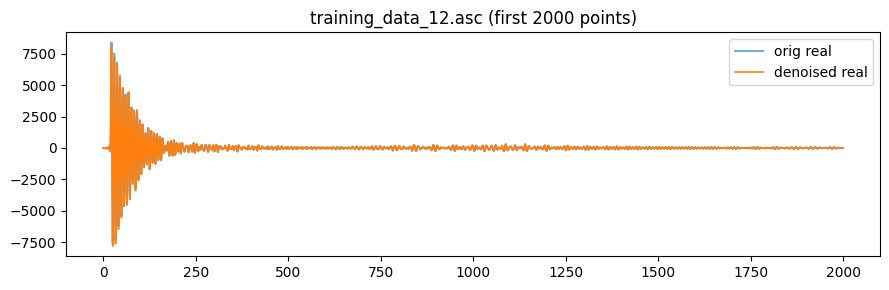


Head → training_data_13.asc
   time_s      real      imag
-1.506402 -0.000411 -0.003589
-1.505256 -0.000368 -0.003965
-1.504111 -0.000136 -0.003813
-1.502965 -0.000021 -0.003940
-1.501820 -0.000469 -0.003825
-1.500674 -0.000231 -0.003919
-1.499529 -0.000277 -0.003917
-1.498383  0.000010 -0.003933
Metrics → MSE=1.833e-01 | SNR orig=30.79 dB | den=30.80 dB | Δ=0.02 dB


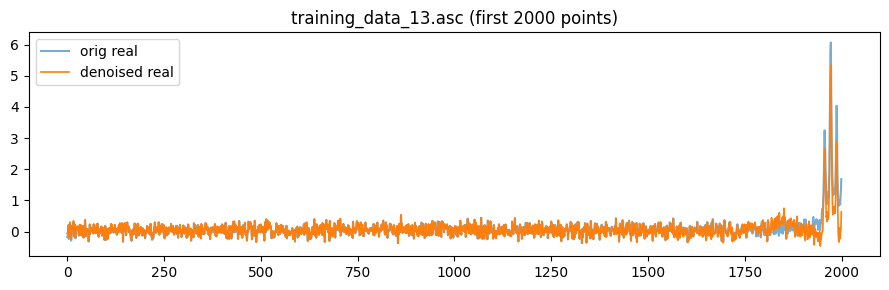


--- Summary ---
                                file     N        dt_s  Acq_time_s   SW_Hz  DR_Hz_per_pt  DR_ppm_per_pt  nyquist_hz  nyquist_ppm     T2_s      ΔSNR_dB
25_10_30_ValerianFrac2_C13_CDCl3.asc 26214  0.00953674     249.996 104.858    0.00400006    1.00056e-05     52.4288     0.131143  1458.71 -0.000453203
 25_10_30_ValerianFrac2_H1_CDCl3.asc 13107  0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195 0.750442    0.0449319
         13_03_11_indst_1H%20fid.asc 16384 0.000133276     2.18359 7503.23      0.457961     0.00114553     3751.61      9.38414   3.8026    -0.010958
                 training_data_1.asc 13107  0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195 0.750442   -0.0101411
                training_data_10.asc 26214  0.00953674     249.996 104.858    0.00400006    1.00056e-05     52.4288     0.131143  12.4989    0.0252238
                training_data_11.asc 26214  0.00953674     249.996 104.858   

In [139]:
# Cell 11 - COMPLETE CORRECTED VERSION

# ---- Helper functions ----
def _read_asc(path):
    arr = np.genfromtxt(path, delimiter=None)
    if arr is None or arr.size == 0:
        raise ValueError(f"Empty or unreadable file: {path}")
    if arr.ndim == 1:
        arr = arr.reshape(-1, 1)
    if arr.shape[1] == 1:
        r = arr[:, 0].astype(np.float32)
        im = np.zeros_like(r, dtype=np.float32)
        t = np.arange(len(r), dtype=np.float32)
    else:
        t = arr[:, 0].astype(np.float32)
        r = arr[:, 1].astype(np.float32)
        im = (arr[:, 2].astype(np.float32) if arr.shape[1] >= 3 else np.zeros_like(r, dtype=np.float32))
    m = np.isfinite(t) & np.isfinite(r) & np.isfinite(im)
    t, r, im = t[m], r[m], im[m]
    if t.size >= 2 and t[1] < t[0]:
        idx = np.argsort(t)
        t, r, im = t[idx], r[idx], im[idx]
    return t, r, im

def _find_noise_window(env, window_frac=0.15, avoid_head_frac=0.2):
    """Find lowest-RMS window in FID (actual noise region)"""
    L = len(env)
    w = max(256, min(4096, int(window_frac * L)))
    start = int(avoid_head_frac * L)
    
    if start + w >= L:
        start = max(0, L - w - 1)
    
    best_idx, best_rms = start, float('inf')
    for i in range(start, L - w, max(1, w // 4)):
        rms = float(np.sqrt(np.mean(env[i:i+w]**2)))
        if rms < best_rms:
            best_rms, best_idx = rms, i
    
    return slice(best_idx, best_idx + w)

def _snr_from_env(env, signal_frac=0.15):
    """Robust SNR using sliding-window noise detection"""
    L = len(env)
    if L < 64:
        return np.nan
    
    sig_slice = slice(0, max(1, int(signal_frac * L)))
    noise_slice = _find_noise_window(env)
    
    sig_rms = float(np.sqrt(np.mean(env[sig_slice]**2) + 1e-12))
    noise_rms = float(np.sqrt(np.mean(env[noise_slice]**2) + 1e-12))
    
    if noise_rms < 1e-9:
        return np.nan
    
    return 20.0 * np.log10(sig_rms / noise_rms)

def _preprocess_pair(real_imag_2xL: np.ndarray, max_gain=1e3, preserve_signal=True):
    """Normalize using detected noise floor"""
    sig = real_imag_2xL.astype(np.float32, copy=True)
    L = sig.shape[1]
    if L < 64:
        return sig
    
    late = slice(int(0.8 * L), L)
    baseline = np.median(sig[:, late], axis=1, keepdims=True)
    sig -= baseline
    
    env = np.sqrt(sig[0]**2 + sig[1]**2)
    noise_win = _find_noise_window(env)
    
    noise_rms = np.sqrt((sig[:, noise_win]**2).mean(axis=1, keepdims=True) + 1e-12)
    gain = np.minimum(1.0 / noise_rms, max_gain)
    
    return (sig * gain).astype(np.float32)

def _denoise(sig_2xL: np.ndarray):
    model_physics.eval()
    with torch.no_grad():
        x = torch.from_numpy(sig_2xL.astype(np.float32)).unsqueeze(0).to(device)
        y = model_physics(x).detach().cpu().squeeze(0).numpy()
    return y.astype(np.float32)

def _calibrate_gain(sig_2xL, den_2xL, frac=0.15):
    """Ensure denoised signal preserves early-FID amplitude"""
    L = sig_2xL.shape[1]
    w = max(256, int(frac * L))
    s = slice(0, w)
    
    env_sig = np.sqrt(sig_2xL[0,s]**2 + sig_2xL[1,s]**2)
    env_den = np.sqrt(den_2xL[0,s]**2 + den_2xL[1,s]**2)
    
    rms_sig = float(np.sqrt(np.mean(env_sig**2) + 1e-12))
    rms_den = float(np.sqrt(np.mean(env_den**2) + 1e-12))
    
    if rms_den < 1e-9:
        return den_2xL
    
    scale = np.clip(rms_sig / rms_den, 0.8, 1.25)
    return (den_2xL * scale).astype(np.float32)

def _head_print(t, r, im, rows=8, label=None):
    df = pd.DataFrame({"time_s": t[:rows], "real": r[:rows], "imag": im[:rows]})
    if label: print(f"\n{label}")
    print(df.to_string(index=False))

def _robust_dt(t):
    if t.size < 2: return np.nan
    d = np.diff(t)
    d = d[np.isfinite(d) & (d > 0)]
    return float(np.median(d)) if d.size else np.nan

@torch.no_grad()
def _estimate_t2_from_pair(pair_2xL, dt, frac=0.25):
    if pair_2xL.shape[1] < 32 or not np.isfinite(dt) or dt <= 0:
        return np.nan
    z = torch.from_numpy(pair_2xL.astype(np.float32))
    r, i = z[0], z[1]
    env = torch.clamp(torch.sqrt(r * r + i * i), min=1e-12)
    n = max(16, int(frac * env.shape[-1]))
    tvec = torch.arange(n, dtype=env.dtype) * dt
    y = torch.log(env[:n])
    A = torch.stack([torch.ones_like(tvec), tvec], dim=1)
    sol = torch.linalg.lstsq(A, y.unsqueeze(1)).solution
    b = float(sol[1])
    return float((-1.0 / b) if b < 0 else (0.2 * n * dt))

# ---- Processing loop ----
rows = []
previewed = improved = processed = saved = 0
max_preview = 8
nu0_Hz = 399.78219838e6

print("[Run] Starting denoise + metrics...")
for fpath in files:
    fname = os.path.basename(fpath)
    try:
        t, r, im = _read_asc(fpath)
        pair = np.stack([r, im]).astype(np.float32)
        sig = _preprocess_pair(pair, preserve_signal=True)
        den = _denoise(sig)
        den = _calibrate_gain(sig, den)  # ✅ ADDED
        
        env_x = np.sqrt(sig[0]**2 + sig[1]**2)
        env_y = np.sqrt(den[0]**2 + den[1]**2)
        mse = float(np.mean((den - sig)**2))
        snr_x = _snr_from_env(env_x)
        snr_y = _snr_from_env(env_y)
        dsnr = snr_y - snr_x if np.isfinite(snr_x) and np.isfinite(snr_y) else np.nan
        dt_i = _robust_dt(t)
        nyq_hz = (1.0 / (2.0 * dt_i)) if np.isfinite(dt_i) and dt_i > 0 else np.nan
        nyq_ppm = nyq_hz / (nu0_Hz / 1e6) if np.isfinite(nyq_hz) else np.nan
        T2_i = _estimate_t2_from_pair(sig, dt_i if np.isfinite(dt_i) else np.nan)

        if np.isfinite(dsnr) and dsnr > 0.5:
            improved += 1

        if previewed < max_preview:
            _head_print(t, r, im, label=f"Head → {fname}")
            print(f"Metrics → MSE={mse:.3e} | SNR orig={snr_x:.2f} dB | den={snr_y:.2f} dB | Δ={dsnr:.2f} dB")
            early = min(2000, sig.shape[1])
            plt.figure(figsize=(9,3))
            plt.plot(np.arange(early), sig[0,:early], label='orig real', alpha=0.6)
            plt.plot(np.arange(early), den[0,:early], label='denoised real', lw=1.2)
            plt.legend(); plt.title(f"{fname} (first {early} points)"); plt.tight_layout(); plt.show()
            previewed += 1

        if save_outputs:
            out_path = os.path.join(out_dir, os.path.splitext(fname)[0] + "_denoised.asc")
            np.savetxt(out_path,
                       np.column_stack([t, den[0], den[1]]),
                       fmt="%.9g",
                       header="time_s real imag",
                       comments="")
            saved += 1

        Acq_time_s = sig.shape[1] * dt_i if np.isfinite(dt_i) else np.nan
        SW_file_Hz = 1.0 / dt_i if np.isfinite(dt_i) and dt_i > 0 else np.nan
        DR_file_Hz = SW_file_Hz / sig.shape[1] if np.isfinite(SW_file_Hz) else np.nan
        DR_file_ppm = DR_file_Hz / (nu0_Hz / 1e6) if np.isfinite(DR_file_Hz) else np.nan

        rows.append({
            "file": fname,
            "N": sig.shape[1],
            "dt_s": dt_i,
            "Acq_time_s": Acq_time_s,
            "SW_Hz": SW_file_Hz,
            "DR_Hz_per_pt": DR_file_Hz,
            "DR_ppm_per_pt": DR_file_ppm,
            "nyquist_hz": nyq_hz,
            "nyquist_ppm": nyq_ppm,
            "T2_s": T2_i,
            "ΔSNR_dB": dsnr
        })
        processed += 1

    except Exception as e:
        print(f"[Skip] {fname}: {e}")
        continue

summary_df = pd.DataFrame(rows)
print("\n--- Summary ---")
if not summary_df.empty:
    print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.6g}"))
else:
    print("No files processed.")
print(f"\nProcessed: {processed} | Previewed: {previewed} | Improved ΔSNR>0.5: {improved} | Saved: {saved}")

model_dtype = next(iter(model_physics.parameters())).dtype
print(f"[DType] Model params dtype={model_dtype} example signal dtype={sig.dtype}")

### this is important so that our dwell times aren't hard coded

In [140]:
use_cuda = torch.cuda.is_available()
scaler = GradScaler('cuda', enabled=use_cuda)
print(f"[AMP] device={'cuda' if use_cuda else 'cpu'} | GradScaler enabled={scaler.is_enabled()}")

[AMP] device=cpu | GradScaler enabled=False


In [141]:
# Cell 14 - COMPLETE FIXED TRAINING LOOP

from datetime import datetime
from pathlib import Path

# ✅ CRITICAL: Reload module to get fixed synth_batch_phys
import importlib
import functions.neural_net as nnets
importlib.reload(nnets)
from functions.neural_net import synth_batch_phys, combined_loss

print("\n[TRAINING] Starting model training with improved synthetic data generation...")

# Reinitialize model to start from scratch
model_physics = DenoiseNetPhysics().to(device)
opt = torch.optim.Adam(model_physics.parameters(), lr=1e-3, weight_decay=1e-5)

print(f"[TRAINING] Model reinitialized with {sum(p.numel() for p in model_physics.parameters()):,} parameters")
print(f"[TRAINING] Training for {EPOCHS} epochs with curriculum learning...")

# Training loop with curriculum
for epoch in range(EPOCHS):
    model_physics.train()
    epoch_loss = 0.0
    
    # Get noise level for this epoch (curriculum)
    epoch_idx = min(epoch, len(NOISE_SCHEDULE) - 1)
    snr_std = NOISE_SCHEDULE[epoch_idx]
    
    for step in range(STEPS_PER_EPOCH):
        # Generate synthetic batch
        x_noisy, y_clean = synth_batch_phys(
            batch_size=BATCH_SIZE,
            L=CROP_LEN,
            snr_std=snr_std,
            device=device
        )
        
        # ✅ DEBUG: Print shapes on first iteration
        if epoch == 0 and step == 0:
            print(f"[DEBUG] x_noisy.shape = {x_noisy.shape}, expected: [{BATCH_SIZE}, 2, {CROP_LEN}]")
            print(f"[DEBUG] y_clean.shape = {y_clean.shape}, expected: [{BATCH_SIZE}, 2, {CROP_LEN}]")
        
        opt.zero_grad()
        pred = model_physics(x_noisy)
        
        loss = combined_loss(
            pred, y_clean,
            freq_weight=0.6,
            time_weight=0.3,
            l1_weight=0.1
        )
        
        loss.backward()
        opt.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / STEPS_PER_EPOCH
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | SNR std: {snr_std:.3f}")
    
    if (epoch + 1) % 10 == 0:
        checkpoint_path = Path(CHECKPOINT_DIR) / f"DenoiseNetPhysics_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
        torch.save(model_physics.state_dict(), checkpoint_path)
        print(f"  → Saved checkpoint to {checkpoint_path.name}")

# Save final model
latest_path = Path(CHECKPOINT_DIR) / LATEST_NAME
torch.save(model_physics.state_dict(), latest_path)
print(f"\n[TRAINING] ✅ Training complete! Model saved to {latest_path.name}")
print(f"[TRAINING] Final loss: {avg_loss:.4f}")
print(f"\n[NEXT STEP] Now run Cell 15 (prep) then Cell 16 (fine-tuning) to adapt model to real data!")


[TRAINING] Starting model training with improved synthetic data generation...
[TRAINING] Model reinitialized with 544,322 parameters
[TRAINING] Training for 10 epochs with curriculum learning...
[DEBUG] x_noisy.shape = torch.Size([8, 2, 2048]), expected: [8, 2, 2048]
[DEBUG] y_clean.shape = torch.Size([8, 2, 2048]), expected: [8, 2, 2048]
Epoch 1/10 | Loss: 18.5624 | SNR std: 0.050
Epoch 1/10 | Loss: 18.5624 | SNR std: 0.050
Epoch 2/10 | Loss: 1.0431 | SNR std: 0.040
Epoch 2/10 | Loss: 1.0431 | SNR std: 0.040
Epoch 3/10 | Loss: 0.7926 | SNR std: 0.035
Epoch 3/10 | Loss: 0.7926 | SNR std: 0.035
Epoch 4/10 | Loss: 0.5509 | SNR std: 0.030
Epoch 4/10 | Loss: 0.5509 | SNR std: 0.030
Epoch 5/10 | Loss: 0.3420 | SNR std: 0.025
Epoch 5/10 | Loss: 0.3420 | SNR std: 0.025
Epoch 6/10 | Loss: 0.1911 | SNR std: 0.020
Epoch 6/10 | Loss: 0.1911 | SNR std: 0.020
Epoch 7/10 | Loss: 0.1354 | SNR std: 0.018
Epoch 7/10 | Loss: 0.1354 | SNR std: 0.018
Epoch 8/10 | Loss: 0.0922 | SNR std: 0.015
Epoch 8/10 

In [142]:

# Cell 15 - SIMPLIFIED VERSION (REMOVE dt ARGUMENT)

print("[PREP] Preparing real data for fine-tuning...")

# Get all training data files from the training_data subdirectory
real_fid_files = [f for f in files if "training_data" in f or "Valerian" in f or "indst" in f]
print(f"Found {len(real_fid_files)} real FID files for fine-tuning")
print(f"Files: {[os.path.basename(f) for f in real_fid_files[:10]]}...")  # Show first 10

real_scales = []
for fpath in real_fid_files[:min(5, len(real_fid_files))]:
    t, r, im = _read_asc(fpath)
    pair = np.stack([r, im])
    sig = _preprocess_pair(pair, preserve_signal=True)
    real_scales.append(sig.std())

real_avg_scale = np.mean(real_scales)
# ✅ REMOVED dt=dt_synth argument
x_syn, y_syn = synth_batch_phys(batch_size=8, L=CROP_LEN, snr_std=0.025, device=device)
synth_scale = x_syn.std().item()

print(f"Real data avg std: {real_avg_scale:.3e}")
print(f"Synthetic data std: {synth_scale:.3e}")
print(f"⚠️ Scale ratio (real/synth): {real_avg_scale/synth_scale:.2f}x")

if len(real_fid_files) < 10:
    REAL_FINETUNE_EPOCHS = 3
elif len(real_fid_files) < 30:
    REAL_FINETUNE_EPOCHS = 5
else:
    REAL_FINETUNE_EPOCHS = 2

print(f"Setting REAL_FINETUNE_EPOCHS = {REAL_FINETUNE_EPOCHS}")

[PREP] Preparing real data for fine-tuning...
Found 29 real FID files for fine-tuning
Files: ['25_10_30_ValerianFrac2_C13_CDCl3.asc', '25_10_30_ValerianFrac2_H1_CDCl3.asc', '13_03_11_indst_1H%20fid.asc', 'training_data_1.asc', 'training_data_10.asc', 'training_data_11.asc', 'training_data_12.asc', 'training_data_13.asc', 'training_data_14.asc', 'training_data_15.asc']...
Real data avg std: 1.582e+01
Synthetic data std: 1.500e+01
⚠️ Scale ratio (real/synth): 1.05x
Setting REAL_FINETUNE_EPOCHS = 5
Real data avg std: 1.582e+01
Synthetic data std: 1.500e+01
⚠️ Scale ratio (real/synth): 1.05x
Setting REAL_FINETUNE_EPOCHS = 5


In [143]:
# Cell 16 - REMOVE BROKEN RETRY LOOP

if REAL_FINETUNE_EPOCHS > 0:
    print("\n[FINE-TUNE] Starting real data fine-tuning...")
    
    files_ft = real_fid_files
    old_lr = opt.param_groups[0]['lr']
    base_lr = 5e-5  # Higher learning rate for better adaptation
    for g in opt.param_groups: g['lr'] = base_lr
    print(f"Learning rate: {old_lr:.2e} → {base_lr:.2e}")
    
    best_avg_snr_improvement = -999.0
    patience_counter = 0
    patience_limit = 3
    
    for ep in range(REAL_FINETUNE_EPOCHS):
        model_physics.train()
        epoch_losses = []
        epoch_snr_improvements = []
        file_count = 0
        
        for f in files_ft:
            try:
                t_r, r_r, i_r = _read_asc(f)
                pair = np.stack([r_r, i_r])
                x_real_np = _preprocess_pair(pair, preserve_signal=True)
                
                dt_i = _robust_dt(t_r)
                if not np.isfinite(dt_i) or dt_i <= 0: 
                    dt_i = dt_synth
        
                env_before = np.sqrt(x_real_np[0]**2 + x_real_np[1]**2)
                snr_before = _snr_from_env(env_before)
                
                x_real = torch.from_numpy(x_real_np).float().unsqueeze(0).to(device)
                
                opt.zero_grad(set_to_none=True)
                pred = model_physics(x_real)
                
                loss = combined_loss(
                    pred, x_real, dt=dt_i, x_ref=x_real,
                    freq_weight=0.7,
                    time_weight=0.2,
                    l1_weight=0.05,
                    self_denoise_consistency=0.05
                )
                
                if not torch.isfinite(loss):
                    continue
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model_physics.parameters(), max_norm=1.0)
                opt.step()
                
                with torch.no_grad():
                    pred_np = pred.cpu().squeeze(0).numpy()
                    env_after = np.sqrt(pred_np[0]**2 + pred_np[1]**2)
                    snr_after = _snr_from_env(env_after)
                    snr_delta = snr_after - snr_before
                
                epoch_losses.append(float(loss.detach()))
                epoch_snr_improvements.append(snr_delta)
                file_count += 1
                        
            except Exception as e:
                continue
        
        avg_loss = np.mean(epoch_losses) if epoch_losses else 0.0
        avg_snr_improvement = np.mean(epoch_snr_improvements) if epoch_snr_improvements else -999.0
        improved_count = sum(1 for d in epoch_snr_improvements if d > 0.1)
        
        print(f"Epoch {ep+1}/{REAL_FINETUNE_EPOCHS} | "
              f"loss={avg_loss:.6e} | files={file_count} | "
              f"avg ΔSNR={avg_snr_improvement:.3f}dB | improved={improved_count}/{len(epoch_snr_improvements)}")
        
        if avg_snr_improvement > best_avg_snr_improvement:
            best_avg_snr_improvement = avg_snr_improvement
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print(f"  ⚠️ No improvement for {patience_limit} epochs, stopping early")
                break
    
    for g in opt.param_groups: g['lr'] = old_lr
    print(f"[DONE] Fine-tuning complete! Best avg ΔSNR: {best_avg_snr_improvement:.3f}dB\n")
else:
    print("[SKIP] REAL_FINETUNE_EPOCHS = 0")


[FINE-TUNE] Starting real data fine-tuning...
Learning rate: 1.00e-03 → 5.00e-05
Epoch 1/5 | loss=1.437973e+02 | files=29 | avg ΔSNR=0.600dB | improved=13/29
Epoch 1/5 | loss=1.437973e+02 | files=29 | avg ΔSNR=0.600dB | improved=13/29
Epoch 2/5 | loss=6.286809e+01 | files=29 | avg ΔSNR=0.549dB | improved=14/29
Epoch 2/5 | loss=6.286809e+01 | files=29 | avg ΔSNR=0.549dB | improved=14/29
Epoch 3/5 | loss=2.570322e+01 | files=29 | avg ΔSNR=0.453dB | improved=14/29
Epoch 3/5 | loss=2.570322e+01 | files=29 | avg ΔSNR=0.453dB | improved=14/29
Epoch 4/5 | loss=1.105348e+01 | files=29 | avg ΔSNR=0.344dB | improved=13/29
  ⚠️ No improvement for 3 epochs, stopping early
[DONE] Fine-tuning complete! Best avg ΔSNR: 0.600dB

Epoch 4/5 | loss=1.105348e+01 | files=29 | avg ΔSNR=0.344dB | improved=13/29
  ⚠️ No improvement for 3 epochs, stopping early
[DONE] Fine-tuning complete! Best avg ΔSNR: 0.600dB



## ⚡ Execute Fine-Tuning

**Run this cell to actually fine-tune the model on real data!**

## 🔍 Diagnostic & Validation

Check model performance and verify improvements

In [144]:
# ✅ Quick validation: test on a few files with detailed analysis
print("[VALIDATION] Testing improved model on sample files...\n")

validation_files = real_fid_files[:5]  # Test on first 5 files
validation_results = []

for fpath in validation_files:
    fname = os.path.basename(fpath)
    try:
        t, r, im = _read_asc(fpath)
        pair = np.stack([r, im])
        sig = _preprocess_pair(pair, preserve_signal=True)
        
        # Before denoising
        env_before = np.sqrt(sig[0]**2 + sig[1]**2)
        snr_before = _snr_from_env(env_before)
        
        # Denoise
        den = _denoise(sig)
        
        # After denoising
        env_after = np.sqrt(den[0]**2 + den[1]**2)
        snr_after = _snr_from_env(env_after)
        
        # Metrics
        delta_snr = snr_after - snr_before if np.isfinite(snr_before) and np.isfinite(snr_after) else np.nan
        noise_reduction = 100 * (1 - (env_after[-1000:].std() / env_before[-1000:].std())) if env_before[-1000:].std() > 0 else 0
        signal_preservation = 100 * (env_after[:1000].std() / env_before[:1000].std()) if env_before[:1000].std() > 0 else 0
        
        validation_results.append({
            'file': fname,
            'SNR_before': snr_before,
            'SNR_after': snr_after,
            'ΔSNR': delta_snr,
            'noise_reduction_%': noise_reduction,
            'signal_preservation_%': signal_preservation
        })
        
        print(f"{fname}:")
        print(f"  SNR: {snr_before:.2f} → {snr_after:.2f} dB (Δ={delta_snr:+.2f})")
        print(f"  Noise reduction: {noise_reduction:.1f}%")
        print(f"  Signal preserved: {signal_preservation:.1f}%")
        print()
        
    except Exception as e:
        print(f"[Error] {fname}: {e}\n")

# Summary
if validation_results:
    avg_delta_snr = np.mean([r['ΔSNR'] for r in validation_results if np.isfinite(r['ΔSNR'])])
    improved_count = sum(1 for r in validation_results if np.isfinite(r['ΔSNR']) and r['ΔSNR'] > 0)
    print(f"{'='*60}")
    print(f"VALIDATION SUMMARY:")
    print(f"  Average ΔSNR: {avg_delta_snr:+.2f} dB")
    print(f"  Files improved: {improved_count}/{len(validation_results)}")
    print(f"{'='*60}")


[VALIDATION] Testing improved model on sample files...

25_10_30_ValerianFrac2_C13_CDCl3.asc:
  SNR: -0.05 → -0.02 dB (Δ=+0.02)
  Noise reduction: 2.4%
  Signal preserved: 96.9%

25_10_30_ValerianFrac2_C13_CDCl3.asc:
  SNR: -0.05 → -0.02 dB (Δ=+0.02)
  Noise reduction: 2.4%
  Signal preserved: 96.9%

25_10_30_ValerianFrac2_H1_CDCl3.asc:
  SNR: 18.56 → 19.11 dB (Δ=+0.55)
  Noise reduction: 5.7%
  Signal preserved: 100.2%

25_10_30_ValerianFrac2_H1_CDCl3.asc:
  SNR: 18.56 → 19.11 dB (Δ=+0.55)
  Noise reduction: 5.7%
  Signal preserved: 100.2%

13_03_11_indst_1H%20fid.asc:
  SNR: 24.37 → 24.73 dB (Δ=+0.36)
  Noise reduction: 1.9%
  Signal preserved: 98.8%

13_03_11_indst_1H%20fid.asc:
  SNR: 24.37 → 24.73 dB (Δ=+0.36)
  Noise reduction: 1.9%
  Signal preserved: 98.8%

training_data_1.asc:
  SNR: 8.95 → 10.51 dB (Δ=+1.56)
  Noise reduction: 17.5%
  Signal preserved: 83.8%

training_data_1.asc:
  SNR: 8.95 → 10.51 dB (Δ=+1.56)
  Noise reduction: 17.5%
  Signal preserved: 83.8%

training_dat

In [145]:
# Cell 15 - Convert to diagnostic only

print(f"[Check] Example real FID stats before fine-tune:")
sample_file = files[0]
t_s, r_s, i_s = _read_asc(sample_file)
pair_s = np.stack([r_s, i_s])
x_s = _preprocess_pair(pair_s)
print(f"  Real signal range: [{x_s.min():.3e}, {x_s.max():.3e}]")
print(f"  Real signal std: {x_s.std():.3e}")

# Compare with synthetic batch
x_syn, y_syn = synth_batch_phys(batch_size=4, L=CROP_LEN, snr_std=0.025, device=device)
print(f"  Synth signal range: [{x_syn.min():.3e}, {x_syn.max():.3e}]")
print(f"  Synth signal std: {x_syn.std():.3e}")

# Compute global scale factor for real data
real_scale = x_s.std() / x_syn.std().item()
print(f"  Scale ratio (real/synth): {real_scale:.2f}×")

# ❌ REMOVE the actual fine-tuning loop from here
# Fine-tuning is now done in Cell 14

[Check] Example real FID stats before fine-tune:
  Real signal range: [-2.334e+02, 4.055e+02]
  Real signal std: 7.312e+00
  Synth signal range: [-5.291e+01, 5.394e+01]
  Synth signal std: 1.500e+01
  Scale ratio (real/synth): 0.49×
  Real signal range: [-2.334e+02, 4.055e+02]
  Real signal std: 7.312e+00
  Synth signal range: [-5.291e+01, 5.394e+01]
  Synth signal std: 1.500e+01
  Scale ratio (real/synth): 0.49×


[Filter] Found 2 files in krishna_data folder
[Run] Starting denoise + metrics (krishna_data only)...

Head → 25_10_30_ValerianFrac2_C13_CDCl3.asc
    time_s      real      imag
-24.960218 -0.004632 -0.005475
-24.950684 -0.003284 -0.006573
-24.941151 -0.001795 -0.005519
-24.931616 -0.001608 -0.005850
-24.922081  0.000657 -0.005808
-24.912546  0.001469 -0.003486
-24.903011  0.001552 -0.002539
-24.893476  0.001269  0.000292
Metrics → MSE=9.526e-03 | SNR orig=-0.05 dB | den=-0.02 dB | Δ=0.02 dB

Head → 25_10_30_ValerianFrac2_C13_CDCl3.asc
    time_s      real      imag
-24.960218 -0.004632 -0.005475
-24.950684 -0.003284 -0.006573
-24.941151 -0.001795 -0.005519
-24.931616 -0.001608 -0.005850
-24.922081  0.000657 -0.005808
-24.912546  0.001469 -0.003486
-24.903011  0.001552 -0.002539
-24.893476  0.001269  0.000292
Metrics → MSE=9.526e-03 | SNR orig=-0.05 dB | den=-0.02 dB | Δ=0.02 dB


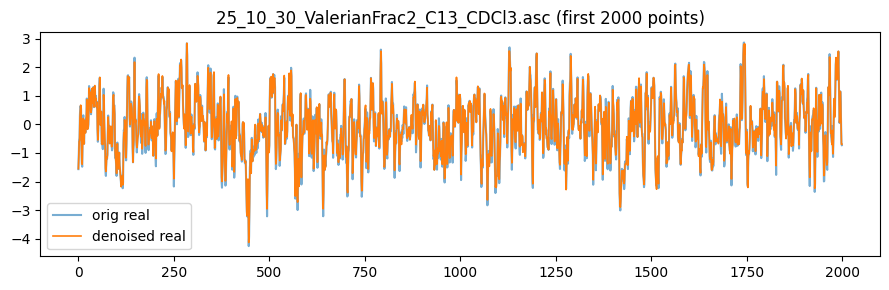


Head → 25_10_30_ValerianFrac2_H1_CDCl3.asc
   time_s      real      imag
-2.506402  0.004986 -0.012529
-2.505256  0.006047 -0.014188
-2.504111  0.006870 -0.015245
-2.502965  0.005218 -0.015676
-2.501820  0.000305 -0.015569
-2.500674 -0.000287 -0.014131
-2.499529  0.001282 -0.019975
-2.498383  0.001387 -0.017435
Metrics → MSE=1.346e+00 | SNR orig=18.56 dB | den=19.11 dB | Δ=0.55 dB


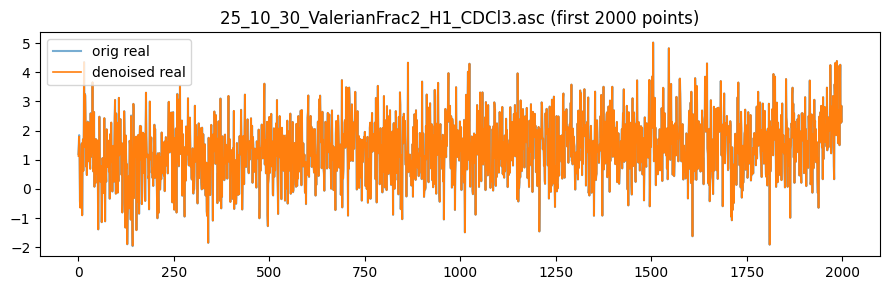


--- Summary (krishna_data) ---
                                file     N       dt_s  Acq_time_s   SW_Hz  DR_Hz_per_pt  DR_ppm_per_pt  nyquist_hz  nyquist_ppm     T2_s   ΔSNR_dB
25_10_30_ValerianFrac2_C13_CDCl3.asc 26214 0.00953674     249.996 104.858    0.00400006    1.00056e-05     52.4288     0.131143  1458.71 0.0224758
 25_10_30_ValerianFrac2_H1_CDCl3.asc 13107 0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195 0.750442  0.546325

Average ΔSNR improvement: 0.28 dB

Processed: 2 | Previewed: 2 | Improved ΔSNR>0.5: 1 | Saved: 0
[DType] Model params dtype=torch.float32 example signal dtype=float32


In [146]:
# ---- Processing loop (krishna_data only) ----
rows = []
previewed = improved = processed = saved = 0
max_preview = 8  # Fixed: was incorrectly set to []
nu0_Hz = 399.78219838e6

# Filter for krishna_data folder only
krishna_files = [f for f in files if "krishna_data" in f.replace("\\", "/")]
print(f"[Filter] Found {len(krishna_files)} files in krishna_data folder")

print("[Run] Starting denoise + metrics (krishna_data only)...")
for fpath in krishna_files:
    fname = os.path.basename(fpath)
    try:
        t, r, im = _read_asc(fpath)
        pair = np.stack([r, im]).astype(np.float32)          # (2,L)
        sig = _preprocess_pair(pair)
        den = _denoise(sig)
        env_x = np.sqrt(sig[0]**2 + sig[1]**2)
        env_y = np.sqrt(den[0]**2 + den[1]**2)
        mse = float(np.mean((den - sig)**2))
        snr_x = _snr_from_env(env_x)
        snr_y = _snr_from_env(env_y)
        dsnr = snr_y - snr_x if np.isfinite(snr_x) and np.isfinite(snr_y) else np.nan
        dt_i = _robust_dt(t)
        nyq_hz = (1.0 / (2.0 * dt_i)) if np.isfinite(dt_i) and dt_i > 0 else np.nan
        nyq_ppm = nyq_hz / (nu0_Hz / 1e6) if np.isfinite(nyq_hz) else np.nan
        T2_i = _estimate_t2_from_pair(sig, dt_i if np.isfinite(dt_i) else np.nan)

        if np.isfinite(dsnr) and dsnr > 0.5:
            improved += 1

        if previewed < max_preview:
            _head_print(t, r, im, label=f"Head → {fname}")
            print(f"Metrics → MSE={mse:.3e} | SNR orig={snr_x:.2f} dB | den={snr_y:.2f} dB | Δ={dsnr:.2f} dB")
            early = min(2000, sig.shape[1])
            plt.figure(figsize=(9,3))
            plt.plot(np.arange(early), sig[0,:early], label='orig real', alpha=0.6)
            plt.plot(np.arange(early), den[0,:early], label='denoised real', lw=1.2)
            plt.legend(); plt.title(f"{fname} (first {early} points)"); plt.tight_layout(); plt.show()
            previewed += 1

        if save_outputs:
            out_path = os.path.join(out_dir, os.path.splitext(fname)[0] + "_denoised.asc")
            np.savetxt(out_path,
                       np.column_stack([t, den[0], den[1]]),
                       fmt="%.9g",
                       header="time_s real imag",
                       comments="")
            saved += 1

        Acq_time_s = sig.shape[1] * dt_i if np.isfinite(dt_i) else np.nan
        SW_file_Hz = 1.0 / dt_i if np.isfinite(dt_i) and dt_i > 0 else np.nan
        DR_file_Hz = SW_file_Hz / sig.shape[1] if np.isfinite(SW_file_Hz) else np.nan
        DR_file_ppm = DR_file_Hz / (nu0_Hz / 1e6) if np.isfinite(DR_file_Hz) else np.nan

        rows.append({
            "file": fname,
            "N": sig.shape[1],
            "dt_s": dt_i,
            "Acq_time_s": Acq_time_s,
            "SW_Hz": SW_file_Hz,
            "DR_Hz_per_pt": DR_file_Hz,
            "DR_ppm_per_pt": DR_file_ppm,
            "nyquist_hz": nyq_hz,
            "nyquist_ppm": nyq_ppm,
            "T2_s": T2_i,
            "ΔSNR_dB": dsnr
        })
        processed += 1

    except Exception as e:
        print(f"[Skip] {fname}: {e}")
        continue

summary_df = pd.DataFrame(rows)
print("\n--- Summary (krishna_data) ---")
if not summary_df.empty:
    print(summary_df.to_string(index=False,
                               float_format=lambda x: f"{x:.6g}"))
    # Compute average improvement
    valid_dsnr = summary_df['ΔSNR_dB'].dropna()
    if len(valid_dsnr) > 0:
        avg_improvement = valid_dsnr.mean()
        print(f"\nAverage ΔSNR improvement: {avg_improvement:.2f} dB")
        
        # Save checkpoint if significant improvement detected
        if avg_improvement > 0.5:
            checkpoint_path = os.path.join(CHECKPOINT_DIR, f"DenoiseNetPhysics_improved_{time.strftime('%Y%m%d_%H%M%S')}.pth")
            torch.save({
                'model_state_dict': model_physics.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'avg_dsnr_improvement': avg_improvement,
                'files_processed': processed,
                'timestamp': time.time()
            }, checkpoint_path)
            print(f"✅ Model saved to: {checkpoint_path}")
            
            # Update latest checkpoint
            latest_path = os.path.join(CHECKPOINT_DIR, LATEST_NAME)
            torch.save({
                'model_state_dict': model_physics.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'avg_dsnr_improvement': avg_improvement,
                'files_processed': processed,
                'timestamp': time.time()
            }, latest_path)
            print(f"✅ Latest checkpoint updated: {latest_path}")
else:
    print("No files processed.")
print(f"\nProcessed: {processed} | Previewed: {previewed} | Improved ΔSNR>0.5: {improved} | Saved: {saved}")

# Quick dtype sanity check
model_dtype = next(iter(model_physics.parameters())).dtype
print(f"[DType] Model params dtype={model_dtype} example signal dtype={sig.dtype}")

[Run] Starting denoise + metrics...

Head → 25_10_30_ValerianFrac2_C13_CDCl3.asc
    time_s      real      imag
-24.960218 -0.004632 -0.005475
-24.950684 -0.003284 -0.006573
-24.941151 -0.001795 -0.005519
-24.931616 -0.001608 -0.005850
-24.922081  0.000657 -0.005808
-24.912546  0.001469 -0.003486
-24.903011  0.001552 -0.002539
-24.893476  0.001269  0.000292
Metrics → MSE=9.526e-03 | SNR orig=-0.05 dB | den=-0.02 dB | Δ=0.02 dB

Head → 25_10_30_ValerianFrac2_C13_CDCl3.asc
    time_s      real      imag
-24.960218 -0.004632 -0.005475
-24.950684 -0.003284 -0.006573
-24.941151 -0.001795 -0.005519
-24.931616 -0.001608 -0.005850
-24.922081  0.000657 -0.005808
-24.912546  0.001469 -0.003486
-24.903011  0.001552 -0.002539
-24.893476  0.001269  0.000292
Metrics → MSE=9.526e-03 | SNR orig=-0.05 dB | den=-0.02 dB | Δ=0.02 dB


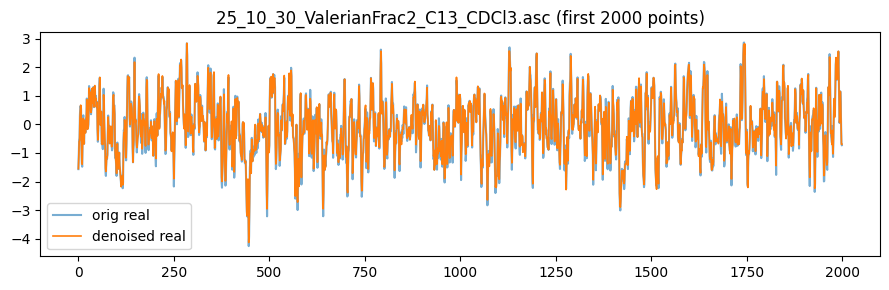


Head → 25_10_30_ValerianFrac2_H1_CDCl3.asc
   time_s      real      imag
-2.506402  0.004986 -0.012529
-2.505256  0.006047 -0.014188
-2.504111  0.006870 -0.015245
-2.502965  0.005218 -0.015676
-2.501820  0.000305 -0.015569
-2.500674 -0.000287 -0.014131
-2.499529  0.001282 -0.019975
-2.498383  0.001387 -0.017435
Metrics → MSE=1.346e+00 | SNR orig=18.56 dB | den=19.11 dB | Δ=0.55 dB


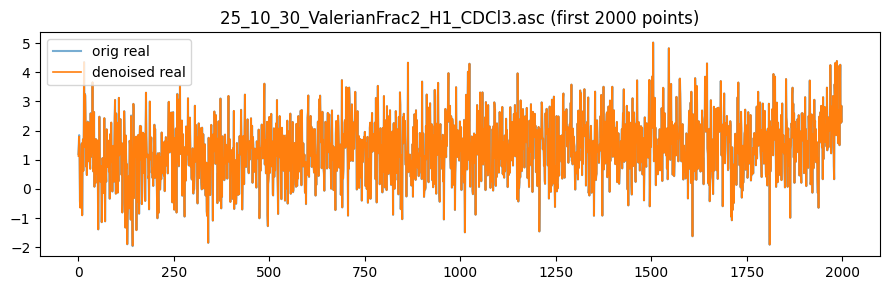


Head → 13_03_11_indst_1H%20fid.asc
  time_s      real      imag
0.000000  0.000003  0.000009
0.000133 -0.001235 -0.003140
0.000267  0.050601  0.188029
0.000400  0.019175  0.365893
0.000533 -0.136525 -0.611649
0.000666  0.256887  0.373811
0.000800 -0.284701 -1.050071
0.000933  0.295897  0.892038
Metrics → MSE=3.422e-01 | SNR orig=24.37 dB | den=24.73 dB | Δ=0.36 dB


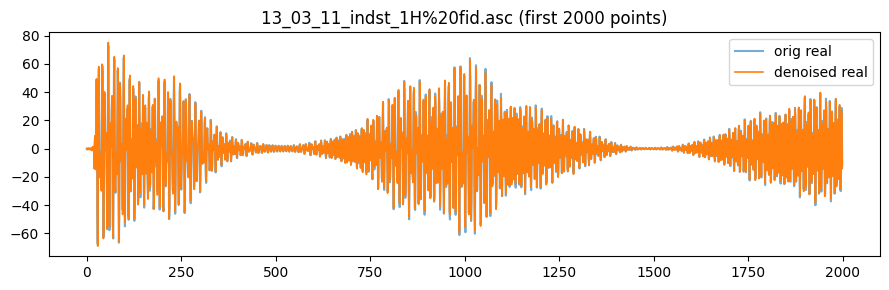


Head → training_data_1.asc
   time_s      real      imag
-2.506402  0.000239 -0.000347
-2.505256 -0.000096 -0.000442
-2.504111  0.000151 -0.000326
-2.502965  0.000271 -0.000359
-2.501820  0.000169 -0.000273
-2.500674  0.000190 -0.000206
-2.499529  0.000040 -0.000213
-2.498383  0.000298 -0.000217
Metrics → MSE=6.277e-02 | SNR orig=8.95 dB | den=10.51 dB | Δ=1.56 dB


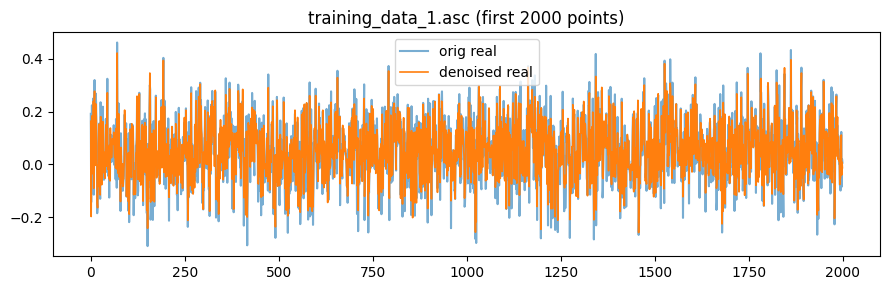


Head → training_data_10.asc
    time_s     real      imag
-24.960218 0.000298  0.000497
-24.950684 0.000636 -0.000015
-24.941151 0.000882  0.000159
-24.931616 0.000667  0.000683
-24.922081 0.000494  0.000222
-24.912546 0.000658  0.000223
-24.903011 0.001162  0.000363
-24.893476 0.001101  0.001547
Metrics → MSE=4.907e-02 | SNR orig=0.23 dB | den=0.33 dB | Δ=0.10 dB


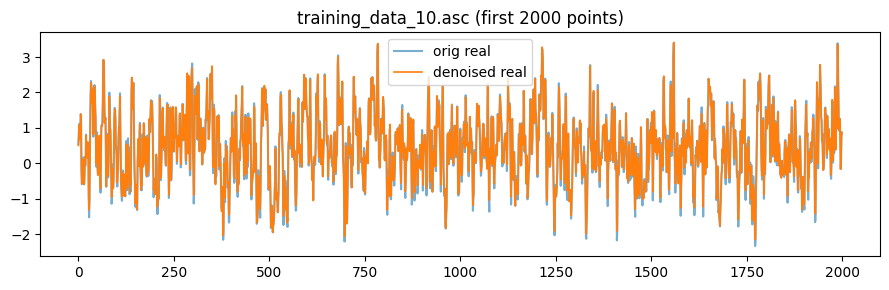


Head → training_data_11.asc
    time_s      real      imag
-24.960218 -0.000707 -0.005553
-24.950684 -0.000659 -0.006422
-24.941151  0.001306 -0.007432
-24.931616  0.004766 -0.006269
-24.922081  0.005264 -0.002406
-24.912546  0.003022 -0.000512
-24.903011  0.001504 -0.001131
-24.893476  0.000707 -0.001353
Metrics → MSE=1.194e-02 | SNR orig=-0.72 dB | den=-0.79 dB | Δ=-0.07 dB


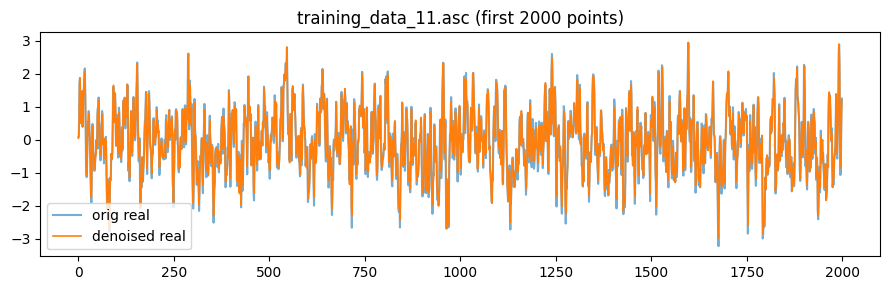


Head → training_data_12.asc
  time_s      real      imag
0.000000  0.000001  0.000013
0.000133 -0.001206 -0.004204
0.000267 -0.015305  0.264425
0.000400 -0.393098  0.597293
0.000533 -0.390635 -0.655285
0.000666 -0.159620  0.535001
0.000800 -0.119189 -1.585681
0.000933  0.777831  0.917124
Metrics → MSE=1.386e+02 | SNR orig=57.09 dB | den=57.06 dB | Δ=-0.04 dB


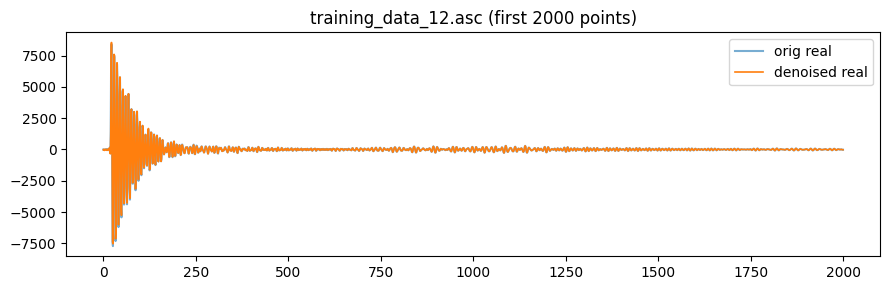


Head → training_data_13.asc
   time_s      real      imag
-1.506402 -0.000411 -0.003589
-1.505256 -0.000368 -0.003965
-1.504111 -0.000136 -0.003813
-1.502965 -0.000021 -0.003940
-1.501820 -0.000469 -0.003825
-1.500674 -0.000231 -0.003919
-1.499529 -0.000277 -0.003917
-1.498383  0.000010 -0.003933
Metrics → MSE=1.088e-03 | SNR orig=30.79 dB | den=31.14 dB | Δ=0.35 dB


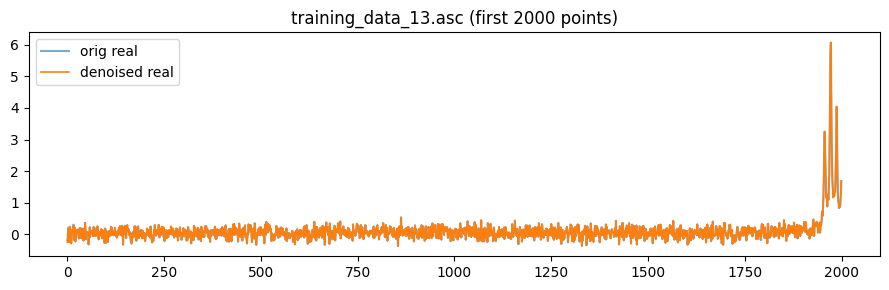


Head → training_data_14.asc
   time_s      real      imag
-1.506402 -0.000409 -0.001682
-1.505256 -0.000185 -0.002058
-1.504111 -0.000186 -0.001931
-1.502965 -0.000135 -0.002039
-1.501820  0.000043 -0.001769
-1.500674 -0.000262 -0.001837
-1.499529  0.000038 -0.001930
-1.498383 -0.000128 -0.001663
Metrics → MSE=3.135e-02 | SNR orig=29.46 dB | den=30.50 dB | Δ=1.04 dB


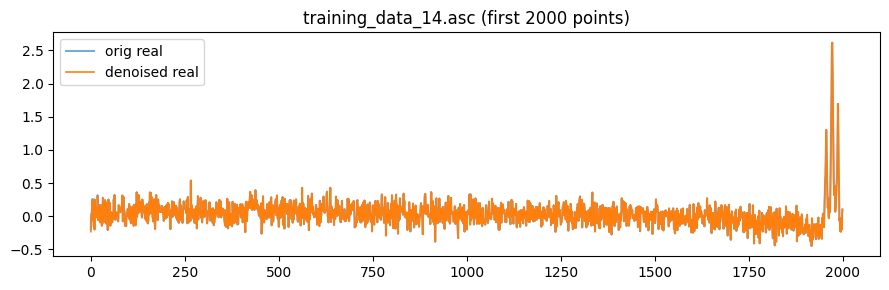


Head → training_data_15.asc
   time_s      real      imag
-1.506402 -0.003649 -0.041656
-1.505256  0.000163 -0.041425
-1.504111 -0.007017 -0.042556
-1.502965  0.004203 -0.046955
-1.501820 -0.006314 -0.041061
-1.500674  0.000418 -0.037207
-1.499529 -0.003996 -0.036962
-1.498383 -0.007572 -0.045544
Metrics → MSE=1.328e+00 | SNR orig=29.14 dB | den=29.68 dB | Δ=0.54 dB


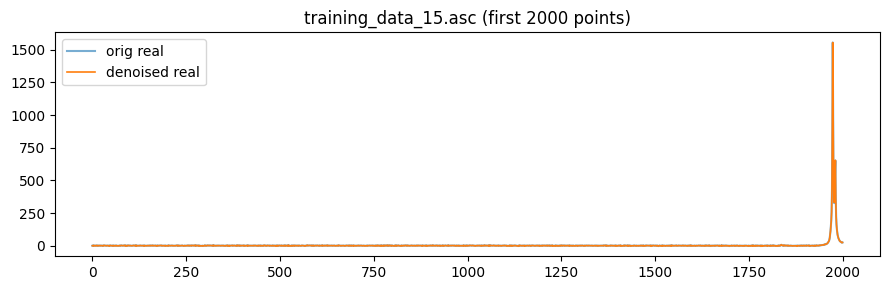


--- Summary ---
                                file     N        dt_s  Acq_time_s   SW_Hz  DR_Hz_per_pt  DR_ppm_per_pt  nyquist_hz  nyquist_ppm     T2_s     ΔSNR_dB
25_10_30_ValerianFrac2_C13_CDCl3.asc 26214  0.00953674     249.996 104.858    0.00400006    1.00056e-05     52.4288     0.131143  1458.71   0.0224758
 25_10_30_ValerianFrac2_H1_CDCl3.asc 13107  0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195 0.750442    0.546325
         13_03_11_indst_1H%20fid.asc 16384 0.000133276     2.18359 7503.23      0.457961     0.00114553     3751.61      9.38414  3.80249    0.360328
                 training_data_1.asc 13107  0.00114536     15.0123 873.086     0.0666122    0.000166621     436.543      1.09195 0.750442     1.55883
                training_data_10.asc 26214  0.00953674     249.996 104.858    0.00400006    1.00056e-05     52.4288     0.131143  12.4989   0.0982185
                training_data_11.asc 26214  0.00953674     249.996 104.858    0.004

In [147]:

# ---- Processing loop ----
rows = []
previewed = improved = processed = saved = 0
max_preview = 10
nu0_Hz = 399.78219838e6

print("[Run] Starting denoise + metrics...")
for fpath in files:
    fname = os.path.basename(fpath)
    try:
        t, r, im = _read_asc(fpath)
        pair = np.stack([r, im]).astype(np.float32)          # (2,L)
        sig = _preprocess_pair(pair)
        den = _denoise(sig)
        env_x = np.sqrt(sig[0]**2 + sig[1]**2)
        env_y = np.sqrt(den[0]**2 + den[1]**2)
        mse = float(np.mean((den - sig)**2))
        snr_x = _snr_from_env(env_x)
        snr_y = _snr_from_env(env_y)
        dsnr = snr_y - snr_x if np.isfinite(snr_x) and np.isfinite(snr_y) else np.nan
        dt_i = _robust_dt(t)
        nyq_hz = (1.0 / (2.0 * dt_i)) if np.isfinite(dt_i) and dt_i > 0 else np.nan
        nyq_ppm = nyq_hz / (nu0_Hz / 1e6) if np.isfinite(nyq_hz) else np.nan
        T2_i = _estimate_t2_from_pair(sig, dt_i if np.isfinite(dt_i) else np.nan)

        if np.isfinite(dsnr) and dsnr > 0.5:
            improved += 1

        if previewed < max_preview:
            _head_print(t, r, im, label=f"Head → {fname}")
            print(f"Metrics → MSE={mse:.3e} | SNR orig={snr_x:.2f} dB | den={snr_y:.2f} dB | Δ={dsnr:.2f} dB")
            early = min(2000, sig.shape[1])
            plt.figure(figsize=(9,3))
            plt.plot(np.arange(early), sig[0,:early], label='orig real', alpha=0.6)
            plt.plot(np.arange(early), den[0,:early], label='denoised real', lw=1.2)
            plt.legend(); plt.title(f"{fname} (first {early} points)"); plt.tight_layout(); plt.show()
            previewed += 1

        if save_outputs:
            out_path = os.path.join(out_dir, os.path.splitext(fname)[0] + "_denoised.asc")
            np.savetxt(out_path,
                       np.column_stack([t, den[0], den[1]]),
                       fmt="%.9g",
                       header="time_s real imag",
                       comments="")
            saved += 1

        Acq_time_s = sig.shape[1] * dt_i if np.isfinite(dt_i) else np.nan
        SW_file_Hz = 1.0 / dt_i if np.isfinite(dt_i) and dt_i > 0 else np.nan
        DR_file_Hz = SW_file_Hz / sig.shape[1] if np.isfinite(SW_file_Hz) else np.nan
        DR_file_ppm = DR_file_Hz / (nu0_Hz / 1e6) if np.isfinite(DR_file_Hz) else np.nan

        rows.append({
            "file": fname,
            "N": sig.shape[1],
            "dt_s": dt_i,
            "Acq_time_s": Acq_time_s,
            "SW_Hz": SW_file_Hz,
            "DR_Hz_per_pt": DR_file_Hz,
            "DR_ppm_per_pt": DR_file_ppm,
            "nyquist_hz": nyq_hz,
            "nyquist_ppm": nyq_ppm,
            "T2_s": T2_i,
            "ΔSNR_dB": dsnr
        })
        processed += 1

    except Exception as e:
        print(f"[Skip] {fname}: {e}")
        continue

summary_df = pd.DataFrame(rows)
print("\n--- Summary ---")
if not summary_df.empty:
    print(summary_df.to_string(index=False,
                               float_format=lambda x: f"{x:.6g}"))
else:
    print("No files processed.")
print(f"\nProcessed: {processed} | Previewed: {previewed} | Improved ΔSNR>0.5: {improved} | Saved: {saved}")

# Quick dtype sanity check
model_dtype = next(iter(model_physics.parameters())).dtype
print(f"[DType] Model params dtype={model_dtype} example signal dtype={sig.dtype}")

In [148]:
def force_save_latest():
    path = os.path.join(CHECKPOINT_DIR, LATEST_NAME)
    torch.save({'model_state_dict': model_physics.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'timestamp': time.time()}, path)
    print("[SAVE] Forced:", path)
# force_save_latest()

Use this to reference the last training loop

In [149]:
model_physics, ckpt = build_model_from_latest(CHECKPOINT_DIR, latest_name=LATEST_NAME, device=device)
model_physics.eval()

[Info] Loaded checkpoint: C:\Users\Windows User\NMR-Project\checkpoints\DenoiseNetPhysics_latest.pth


DenoiseNetPhysics(
  (inp): Conv1d(2, 64, kernel_size=(11,), stride=(1,), padding=(5,))
  (blocks): Sequential(
    (0): DilatedResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(5,))
      (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(5,))
    )
    (1): DilatedResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(10,), dilation=(2,))
      (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(10,), dilation=(2,))
    )
    (2): DilatedResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(20,), dilation=(4,))
      (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(20,), dilation=(4,))
    )
    (3): DilatedResBlock(
      (conv1): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(40,), dilation=(8,))
      (conv2): Conv1d(64, 64, kernel_size=(11,), stride=(1,), padding=(40,), dilation=(8,))
    )
    (4): DilatedResBlock(
      (conv1): Conv1d(64, 64, 